In [ ]:
!pip install d2l

In [ ]:
# 预训练
import os
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
import time

start = time.perf_counter()

pretrained_net = torchvision.models.resnet18(pretrained=True)
net = pretrained_net
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.conv1.weight.data = pretrained_net.conv1.weight[:,:1,:,:]
net.fc = nn.Linear(net.fc.in_features, 10)
nn.init.xavier_uniform_(net.fc.weight);

def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=10,
                      param_group=True):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD(
                                [{'params': params_1x},
                               {'params': net.fc.parameters(),
                                'lr': learning_rate * 10}],
                              lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                              weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

train_fine_tuning(net, 5e-5)

end = time.perf_counter()
print(end-start)

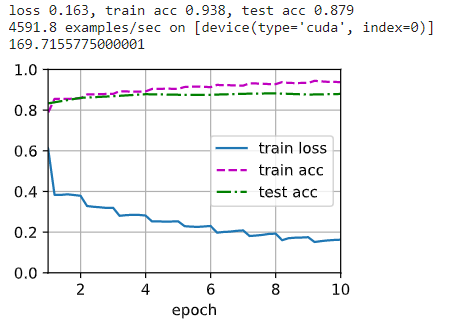

In [ ]:
# 预训练加增广
import os
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
import time

start = time.perf_counter()

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))])

def load_data_fashion_mnist(batch_size): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=train_augs, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=test_augs, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

pretrained_net = torchvision.models.resnet18(pretrained=True)
net = pretrained_net
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.conv1.weight.data = pretrained_net.conv1.weight[:,:1,:,:]
net.fc = nn.Linear(net.fc.in_features, 10)
nn.init.xavier_uniform_(net.fc.weight);


# 如果param_group=True，输出层中的模型参数将使⽤⼗倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=10,
                      param_group=True):
    train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD(
                                [{'params': params_1x},
                               {'params': net.fc.parameters(),
                                'lr': learning_rate * 10}],
                              lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                              weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

train_fine_tuning(net, 5e-5)

end = time.perf_counter()
print(end-start)

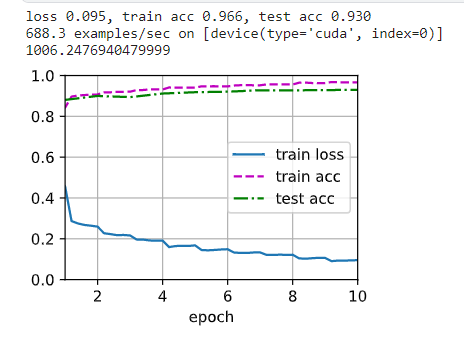

In [ ]:
# 预训练加增广加senet
import os
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
import time

start = time.perf_counter()

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))])

def load_data_fashion_mnist(batch_size): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=train_augs, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=test_augs, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(planes, planes // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(planes // 16, planes, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out2 = self.se(out)
        out = out * out2

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64  # 第一个残差块的输入通道数
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Stage1 ~ Stage4
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # GAP
        self.last = nn.Linear(512 , num_classes)

        # 网络参数初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.last(x)

        return x

net = ResNet(BasicBlock, [2, 2, 2, 2])
# print(model)

pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_dict = pretrained_net.state_dict()
model_dict = net.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict)
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.conv1.weight.data = pretrained_net.conv1.weight[:,:1,:,:]


# 如果param_group=True，输出层中的模型参数将使⽤⼗倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=10,
                      param_group=True):
    train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["last.weight", "last.bias"]]
        trainer = torch.optim.SGD(
                                [{'params': params_1x},
                               {'params': net.last.parameters(),
                                'lr': learning_rate * 10}],
                              lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                              weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

train_fine_tuning(net, 5e-5)
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

end = time.perf_counter()
print(end-start)

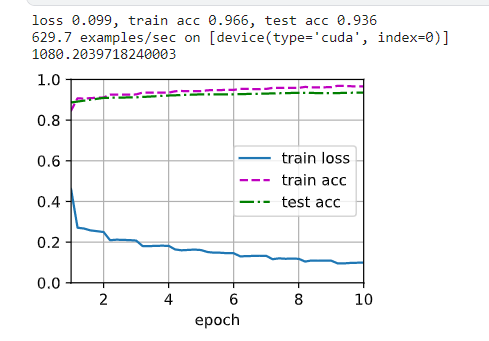